In [ ]:
%pip install torchinfo

In [ ]:
### library imports

# basic libraries for matrix manipulation
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

# for reading and displaying images
import matplotlib.pyplot as plt
%matplotlib inline

# PyTorch libraries and modules for building cnn from scratch
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR

# for printing pytorch cnn model summary
from torchinfo import summary

In [ ]:
%time
!git clone https://github.com/haroldlkh/school_image_datasets.git

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.72 µs
Cloning into 'school_image_datasets'...
remote: Enumerating objects: 5859, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 5859 (delta 0), reused 3 (delta 0), pack-reused 5856
Receiving objects: 100% (5859/5859), 1.46 GiB | 28.58 MiB/s, done.
Checking out files: 100% (5849/5849), done.


Building CNN from scratch - with 28x28 images as inputs (same as MNIST)

- Base model based on PyTorch Github CNN Example that was done on the MNIST dataset
- Additionally we added normalization of images in our model

In [ ]:
### CNN Training settings
# input batch size for training (github example default: 64)
batch_size = 64
# input batch size for testing (github example default: 1000)
test_batch_size = 1000
# number of epochs to train (github example default: 14)
epochs = 10
# learning rate (github example default: 1.0)
lr = 1.0
# Learning rate step gamma (github example default: 0.7)
gamma = 0.7
# disables CUDA training (github example default: False, leave CUDA on if available)
no_cuda = False
# random seed (github example default: 1)
seed = 1
# For Saving the current Model (github example default: False)
save_model = False

In [ ]:
### code to load dataset for 28 x 28 input
# note that we will not use a validation set (because we are not tuning any model parameters)
# we split the data 80/20 between train/test, to remain consistent with our other methods for results comparision purposes

img_size = 28
resize = torchvision.transforms.Resize((img_size, img_size))
to_tensor = torchvision.transforms.ToTensor()
transform = torchvision.transforms.Compose([resize, to_tensor])

ds = torchvision.datasets.ImageFolder("/content/school_image_datasets/data607/plant_diseases", transform=transform)

# set random seed to 1 for our split for comparible results
torch.manual_seed(1)

n=len(ds)
n_tr=int(n*.8)
n_te=n-n_tr
ds_train, ds_test = torch.utils.data.random_split(ds, [n_tr, n_te])

dl_train = torch.utils.data.DataLoader(ds_train, batch_size=32, shuffle=True)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=len(ds_test))

# add normalizer
x, y = next(iter(dl_train))
mean = torch.mean(x, dim=[0, 2, 3])
std = torch.std(x, dim=[0, 2, 3])
print(mean, std)
normalizer = torchvision.transforms.Normalize(mean, std)

tensor([0.4894, 0.6036, 0.4220]) tensor([0.1742, 0.1488, 0.1745])


CUDA Not Available, CPU in use
Layer (type:depth-idx)                   Output Shape              Param #
Net                                      --                        --
├─Conv2d: 1-1                            [64, 32, 26, 26]          896
├─Conv2d: 1-2                            [64, 64, 24, 24]          18,496
├─Dropout: 1-3                           [64, 64, 12, 12]          --
├─Linear: 1-4                            [64, 128]                 1,179,776
├─Dropout: 1-5                           [64, 128]                 --
├─Linear: 1-6                            [64, 3]                   387
Total params: 1,199,555
Trainable params: 1,199,555
Non-trainable params: 0
Total mult-adds (M): 796.13
Input size (MB): 0.60
Forward/backward pass size (MB): 30.02
Params size (MB): 4.80
Estimated Total Size (MB): 35.42


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1: Train loss: 0.7899, Train acc: 880/1225 (72%), Test loss: 0.7899, Test acc: 206/307 (67%)
Epoch 2: Train loss: 0.5647, Train acc: 1060/1225 (87%), Test loss: 0.5647, Test acc: 249/307 (81%)
Epoch 3: Train loss: 0.4861, Train acc: 1089/1225 (89%), Test loss: 0.4861, Test acc: 246/307 (80%)
Epoch 4: Train loss: 0.4205, Train acc: 1127/1225 (92%), Test loss: 0.4205, Test acc: 261/307 (85%)
Epoch 5: Train loss: 0.3937, Train acc: 1147/1225 (94%), Test loss: 0.3937, Test acc: 261/307 (85%)
Epoch 6: Train loss: 0.3961, Train acc: 1159/1225 (95%), Test loss: 0.3961, Test acc: 262/307 (85%)
Epoch 7: Train loss: 0.3911, Train acc: 1169/1225 (95%), Test loss: 0.3911, Test acc: 260/307 (85%)
Epoch 8: Train loss: 0.3880, Train acc: 1169/1225 (95%), Test loss: 0.3880, Test acc: 261/307 (85%)
Epoch 9: Train loss: 0.3807, Train acc: 1175/1225 (96%), Test loss: 0.3807, Test acc: 261/307 (85%)
Epoch 10: Train loss: 0.3815, Train acc: 1173/1225 (96%), Test loss: 0.3815, Test acc: 260/307 (85%)


epoch  training accuracy  testing accuracy  training loss  testing loss
0      1           0.718367          0.671010       0.647189      0.789908
1      2           0.865306          0.811075       0.364578      0.564665
2      3           0.888980          0.801303       0.287850      0.486140
3      4           0.920000          0.850163       0.222129      0.420525
4      5           0.936327          0.850163       0.187744      0.393700
5      6           0.946122          0.853420       0.166966      0.396135
6      7           0.954286          0.846906       0.153072      0.391150
7      8           0.954286          0.850163       0.144831      0.387989
8      9           0.959184          0.850163       0.136379      0.380718
9     10           0.957551          0.846906       0.133576      0.381450

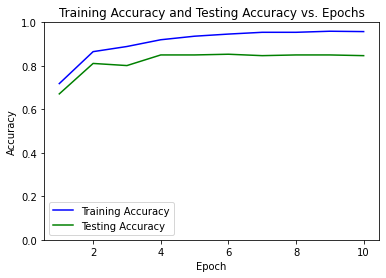

In [ ]:
# define model
# code from examples given on pytorch github
# basis of model is PyTorch example for classifying MNIST dataset
# image size set to 28x28 (same as the MNIST dataset which this example model was originaly used for on pytorch github)
# changed epoch from 14 t0 10 to save time
# also added in normalization of data as well as random horizontal / vertical flips
# https://github.com/pytorch/examples/blob/main/mnist/main.py
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        # normalize image based on mean and std
        x = normalizer(x)
        # convolution layer 1, learn 32 filters using 3x3 kernal, relu activation
        x = self.conv1(x)
        x = F.relu(x)
        # convolution layer 2, learn 64 filters using 3x3 kernal, relu activation
        x = self.conv2(x)
        x = F.relu(x)
        # max-pooling layer, using 2x2 pool size
        x = F.max_pool2d(x, 2)
        # 25% dropout
        x = self.dropout1(x)
        # flattening layer
        x = torch.flatten(x, 1)
        # Fully connected hidden layer with 128 units, relu activation
        x = self.fc1(x)
        x = F.relu(x)
        # 50% dropout
        x = self.dropout2(x)
        # output layer with 3 units, softmax activation (for muticlass classification)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

# function to train model
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

# function to test our model after each epoch, returns train_loss, train_acc, test_loss, test_acc
def test(model, device, train_loader, test_loader, epoch):
    model.eval()
    test_loss = 0
    test_correct = 0
    train_loss = 0
    train_correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            test_correct += pred.eq(target.view_as(pred)).sum().item()
    with torch.no_grad():
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            train_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            train_correct += pred.eq(target.view_as(pred)).sum().item()

    train_loss /= len(train_loader.dataset)
    train_acc = train_correct / len(train_loader.dataset)
    test_loss /= len(test_loader.dataset)
    test_acc = test_correct / len(test_loader.dataset)

    print('Epoch {}: Train loss: {:.4f}, Train acc: {}/{} ({:.0f}%), Test loss: {:.4f}, Test acc: {}/{} ({:.0f}%)'.format(
        epoch, 
        test_loss, train_correct, len(train_loader.dataset),
        100. * train_acc,
        test_loss, test_correct, len(test_loader.dataset),
        100. * test_acc))
    
    return train_loss, train_acc, test_loss, test_acc

# lists to store results
train_loss_list = list()
train_acc_list = list()
test_loss_list = list()
test_acc_list = list()

### main cnn codes
use_cuda = not no_cuda and torch.cuda.is_available()

torch.manual_seed(seed)

device = torch.device("cuda" if use_cuda else "cpu")
if use_cuda:
  print("CUDA Available:", torch.cuda.is_available(), ". GPU in use:", torch.cuda.get_device_name())
else:
  print("CUDA Not Available, CPU in use")


train_kwargs = {'batch_size': batch_size}
test_kwargs = {'batch_size': test_batch_size}
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                    'pin_memory': True,
                    'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

cnn_model = Net().to(device)
# show model
print(summary(cnn_model, input_size=(batch_size, 3, img_size, img_size)))
# Optimizer that implements the Adadelta algorithm (same as github example). 
# Adadelta optimization is a stochastic gradient descent method that is based on adaptive learning rate per dimension.
optimizer = optim.Adadelta(cnn_model.parameters(), lr=lr)

# main train model code
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
for epoch in tqdm(range(1, epochs + 1)):
    train(cnn_model, device, dl_train, optimizer, epoch)
    train_loss, train_acc, test_loss, test_acc = test(cnn_model, device, dl_train, dl_test, epoch)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    scheduler.step()

# if we want to save the model, this code here saves it
if save_model:
    torch.save(cnn_model.state_dict(), "plant_disease_torch_cnn.pt")

# print results in table
np.arange(1,11,1)
d = {'epoch': np.arange(1,11,1), 'training accuracy': train_acc_list, 'testing accuracy': test_acc_list, 
      'training loss': train_loss_list, 'testing loss': test_loss_list}
df = pd.DataFrame(data=d)
display(df)

# display results on plot
plt.plot(np.arange(1,11,1), train_acc_list, label = 'Training Accuracy', color = 'blue')
plt.plot(np.arange(1,11,1), test_acc_list, label = 'Testing Accuracy', color = 'green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower left')
plt.title('Training Accuracy and Testing Accuracy vs. Epochs')
plt.show()

plt.plot(np.arange(1,11,1), train_loss_list, label='Training loss', color = 'orange')
plt.plot(np.arange(1,11,1), test_loss_list, label='Testing loss', color = 'red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower left')
plt.title('Training Loss and Testing Loss vs. Epochs')
plt.show()

Building CNN from scratch - with 128x128 images as inputs

- Base model based on PyTorch Github CNN Example that was done on the MNIST dataset
- Additionally we added normalization of images in our model

In [ ]:
### code to load dataset for 128 x 128 input
# note that we will not use a validation set (because we are not tuning any model parameters)
# we split the data 80/20 between train/test, to remain consistent with our other methods for results comparision purposes

img_size = 128
resize = torchvision.transforms.Resize((img_size, img_size))
to_tensor = torchvision.transforms.ToTensor()
transform = torchvision.transforms.Compose([resize, to_tensor])

ds = torchvision.datasets.ImageFolder("/content/school_image_datasets/data607/plant_diseases", transform=transform)

# set random seed to 1 for our split for comparible results
torch.manual_seed(1)

n=len(ds)
n_tr=int(n*.8)
n_te=n-n_tr
ds_train, ds_test = torch.utils.data.random_split(ds, [n_tr, n_te])

dl_train = torch.utils.data.DataLoader(ds_train, batch_size=32, shuffle=True)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=len(ds_test))

# add normalizer and random flips
x, y = next(iter(dl_train))
mean = torch.mean(x, dim=[0, 2, 3])
std = torch.std(x, dim=[0, 2, 3])
print(mean, std)
normalizer = torchvision.transforms.Normalize(mean, std)

tensor([0.4894, 0.6036, 0.4219]) tensor([0.1905, 0.1634, 0.1914])


In [ ]:
### CNN Training settings kept same as the previous run with the 28 x 28 images

# for our own info, this is the mapping of labels
categories_dict = {"Healthy": 0, "Powdery": 1, "Rust": 2}

# helper dictionary for printing out our predictions later (this is reverse of categories_dict)
labels_dict = {v: k for k, v in categories_dict.items()} 

# define model
# code from examples given on pytorch github
# basis of model is PyTorch example for classifying MNIST dataset
# increased image size from 28x28 to 128x128
# changed epoch from 14 t0 10 to save time
# also added in normalization of data as well as random horizontal / vertical flips
# https://github.com/pytorch/examples/blob/main/mnist/main.py
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(246016, 128)
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        # normalize image based on mean and std
        x = normalizer(x)
        # convolution layer 1, learn 32 filters using 3x3 kernal, relu activation
        x = self.conv1(x)
        x = F.relu(x)
        # convolution layer 2, learn 64 filters using 3x3 kernal, relu activation
        x = self.conv2(x)
        x = F.relu(x)
        # max-pooling layer, using 2x2 pool size
        x = F.max_pool2d(x, 2)
        # 25% dropout
        x = self.dropout1(x)
        # flattening layer
        x = torch.flatten(x, 1)
        # Fully connected hidden layer with 128 units, relu activation
        x = self.fc1(x)
        x = F.relu(x)
        # 50% dropout
        x = self.dropout2(x)
        # output layer with 3 units, softmax activation (for muticlass classification)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

# function to train model
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

# function to test our model after each epoch, returns train_loss, train_acc, test_loss, test_acc
def test(model, device, train_loader, test_loader, epoch):
    model.eval()
    test_loss = 0
    test_correct = 0
    train_loss = 0
    train_correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            test_correct += pred.eq(target.view_as(pred)).sum().item()
    with torch.no_grad():
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            train_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            train_correct += pred.eq(target.view_as(pred)).sum().item()

    train_loss /= len(train_loader.dataset)
    train_acc = train_correct / len(train_loader.dataset)
    test_loss /= len(test_loader.dataset)
    test_acc = test_correct / len(test_loader.dataset)

    print('Epoch {}: Train loss: {:.4f}, Train acc: {}/{} ({:.0f}%), Test loss: {:.4f}, Test acc: {}/{} ({:.0f}%)'.format(
        epoch, 
        test_loss, train_correct, len(train_loader.dataset),
        100. * train_acc,
        test_loss, test_correct, len(test_loader.dataset),
        100. * test_acc))
    
    return train_loss, train_acc, test_loss, test_acc

# lists to store results
train_loss_list = list()
train_acc_list = list()
test_loss_list = list()
test_acc_list = list()

### main cnn codes
use_cuda = not no_cuda and torch.cuda.is_available()

torch.manual_seed(seed)

device = torch.device("cuda" if use_cuda else "cpu")
if use_cuda:
  print("CUDA Available:", torch.cuda.is_available(), ". GPU in use:", torch.cuda.get_device_name())
else:
  print("CUDA Not Available, CPU in use")


train_kwargs = {'batch_size': batch_size}
test_kwargs = {'batch_size': test_batch_size}
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                    'pin_memory': True,
                    'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

cnn_model = Net().to(device)
# show model
print(summary(cnn_model, input_size=(batch_size, 3, img_size, img_size)))
# Optimizer that implements the Adadelta algorithm (same as github example). 
# Adadelta optimization is a stochastic gradient descent method that is based on adaptive learning rate per dimension.
optimizer = optim.Adadelta(cnn_model.parameters(), lr=lr)


# find index's for 9 random images for graphing later on (for presentation)
# out of the 9 images, we will have 3 healthy, 3 powdery, 3 rust
# and we will layout our images later in a 3 x 3 format
sample_idx_list = list()
cols, rows = 3, 3
for i in range(0, cols * rows):
  target_label = i % 3
  sample_idx = torch.randint(len(ds_test), size=(1,)).item()
  img, label = ds_test[sample_idx]
  while label != target_label:
    sample_idx = torch.randint(len(ds_test), size=(1,)).item()
    img, label = ds_test[sample_idx]
  sample_idx_list.append(sample_idx)

# main code to train model while also collecting prediction info for graphing later on (for presentation)
# these 3 lists are used to store the results for the prediction info for graphing later on (for presentation)
img_list_2d = list()
label_list_2d = list()
predicted_class_list_2d = list()

scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
for epoch in tqdm(range(1, epochs + 1)):
    train(cnn_model, device, dl_train, optimizer, epoch)
    train_loss, train_acc, test_loss, test_acc = test(cnn_model, device, dl_train, dl_test, epoch)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    # get some sample predictions for graphing later
    with torch.no_grad():
      # create 1d list to store results for this epoch
      img_list = list()
      label_list = list()
      predicted_class_list = list()
      for i in range(0, cols * rows):
        sample_idx = sample_idx_list[i]
        img, label = ds_test[sample_idx]
        prediction = cnn_model(img.to(device).unsqueeze(0))
        # print(prediction)
        predicted_class = prediction.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        # add results to 1d list
        img_list.append(img)
        label_list.append(label)
        predicted_class_list.append(predicted_class)
      # append this epoch's result to the overall list that stores results for all epochs
      img_list_2d.append(img_list)
      label_list_2d.append(label_list)
      predicted_class_list_2d.append(predicted_class_list)
    scheduler.step()

# if we want to save the model, this code here saves it
if save_model:
    torch.save(cnn_model.state_dict(), "plant_disease_torch_cnn.pt")


CUDA Not Available, CPU in use
Layer (type:depth-idx)                   Output Shape              Param #
Net                                      --                        --
├─Conv2d: 1-1                            [64, 32, 126, 126]        896
├─Conv2d: 1-2                            [64, 64, 124, 124]        18,496
├─Dropout: 1-3                           [64, 64, 62, 62]          --
├─Linear: 1-4                            [64, 128]                 31,490,176
├─Dropout: 1-5                           [64, 128]                 --
├─Linear: 1-6                            [64, 3]                   387
Total params: 31,509,955
Trainable params: 31,509,955
Non-trainable params: 0
Total mult-adds (G): 21.13
Input size (MB): 12.58
Forward/backward pass size (MB): 764.02
Params size (MB): 126.04
Estimated Total Size (MB): 902.64


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1: Train loss: 0.7428, Train acc: 961/1225 (78%), Test loss: 0.7428, Test acc: 218/307 (71%)
Epoch 2: Train loss: 0.5078, Train acc: 1084/1225 (88%), Test loss: 0.5078, Test acc: 250/307 (81%)
Epoch 3: Train loss: 0.4824, Train acc: 1146/1225 (94%), Test loss: 0.4824, Test acc: 256/307 (83%)
Epoch 4: Train loss: 0.3996, Train acc: 1185/1225 (97%), Test loss: 0.3996, Test acc: 266/307 (87%)
Epoch 5: Train loss: 0.2990, Train acc: 1200/1225 (98%), Test loss: 0.2990, Test acc: 271/307 (88%)
Epoch 6: Train loss: 0.3633, Train acc: 1198/1225 (98%), Test loss: 0.3633, Test acc: 274/307 (89%)
Epoch 7: Train loss: 0.2992, Train acc: 1220/1225 (100%), Test loss: 0.2992, Test acc: 277/307 (90%)
Epoch 8: Train loss: 0.3156, Train acc: 1220/1225 (100%), Test loss: 0.3156, Test acc: 272/307 (89%)
Epoch 9: Train loss: 0.3308, Train acc: 1221/1225 (100%), Test loss: 0.3308, Test acc: 277/307 (90%)
Epoch 10: Train loss: 0.3404, Train acc: 1221/1225 (100%), Test loss: 0.3404, Test acc: 277/307 (9

epoch  training accuracy  testing accuracy  training loss  testing loss
0      1           0.784490          0.710098       0.551147      0.742772
1      2           0.884898          0.814332       0.303541      0.507815
2      3           0.935510          0.833876       0.212188      0.482369
3      4           0.967347          0.866450       0.104671      0.399626
4      5           0.979592          0.882736       0.070075      0.299040
5      6           0.977959          0.892508       0.065124      0.363258
6      7           0.995918          0.902280       0.027704      0.299242
7      8           0.995918          0.885993       0.025148      0.315562
8      9           0.996735          0.902280       0.020082      0.330773
9     10           0.996735          0.902280       0.017802      0.340430

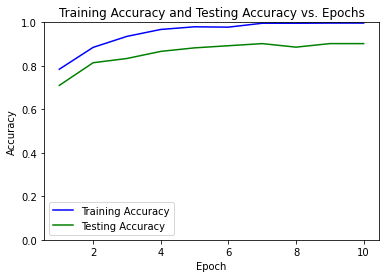

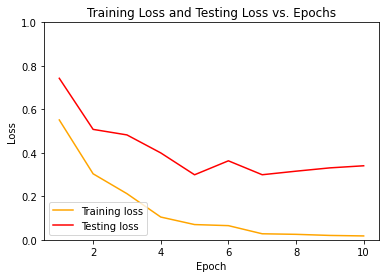

In [ ]:
# print results in table
np.arange(1,11,1)
d = {'epoch': np.arange(1,11,1), 'training accuracy': train_acc_list, 'testing accuracy': test_acc_list, 
      'training loss': train_loss_list, 'testing loss': test_loss_list}
df = pd.DataFrame(data=d)
display(df)

# display results on plot
plt.plot(np.arange(1,11,1), train_acc_list, label = 'Training Accuracy', color = 'blue')
plt.plot(np.arange(1,11,1), test_acc_list, label = 'Testing Accuracy', color = 'green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower left')
plt.title('Training Accuracy and Testing Accuracy vs. Epochs')
plt.show()

plt.plot(np.arange(1,11,1), train_loss_list, label='Training loss', color = 'orange')
plt.plot(np.arange(1,11,1), test_loss_list, label='Testing loss', color = 'red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower left')
plt.title('Training Loss and Testing Loss vs. Epochs')
plt.show()

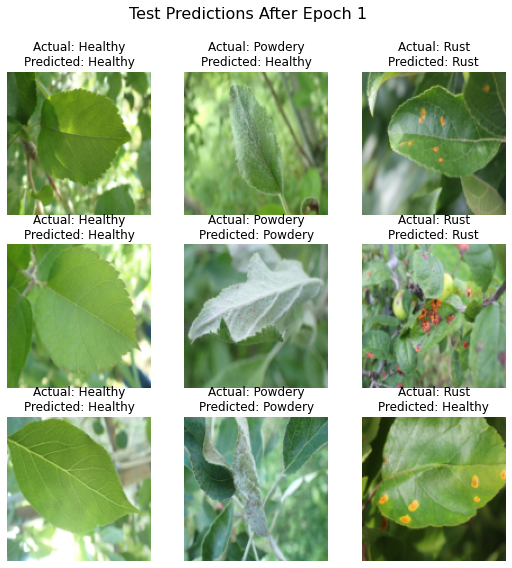

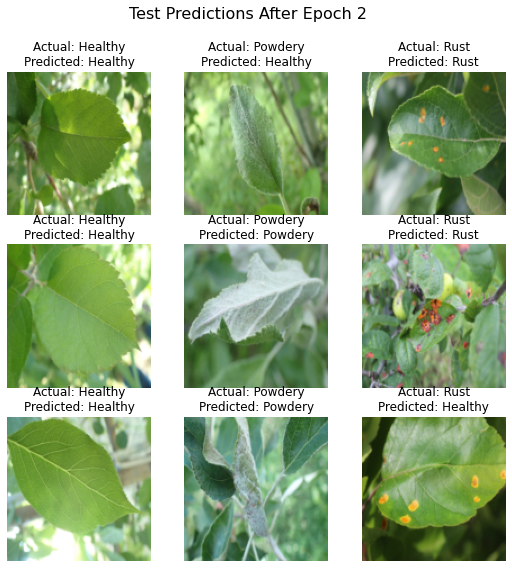

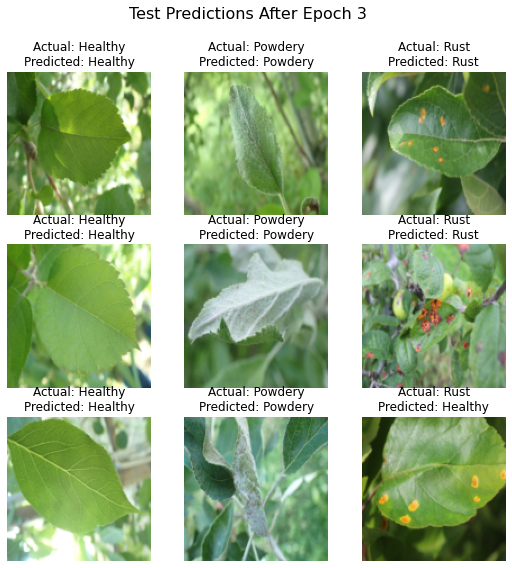

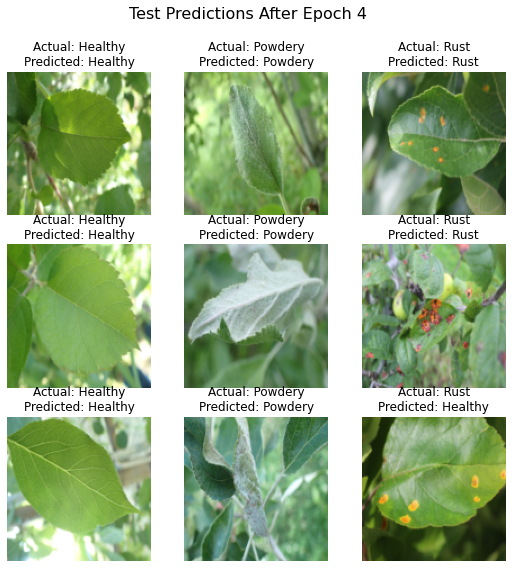

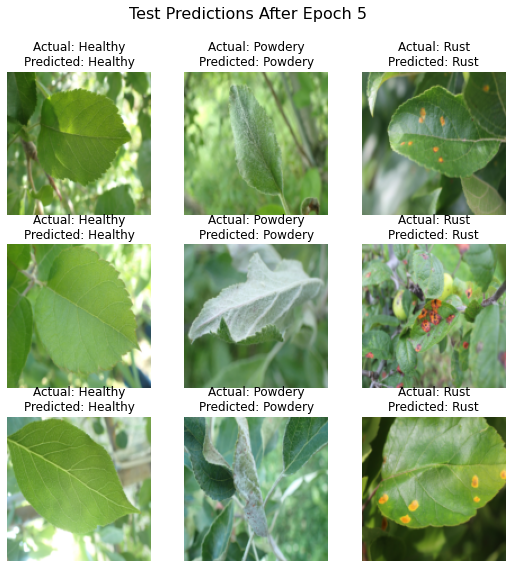

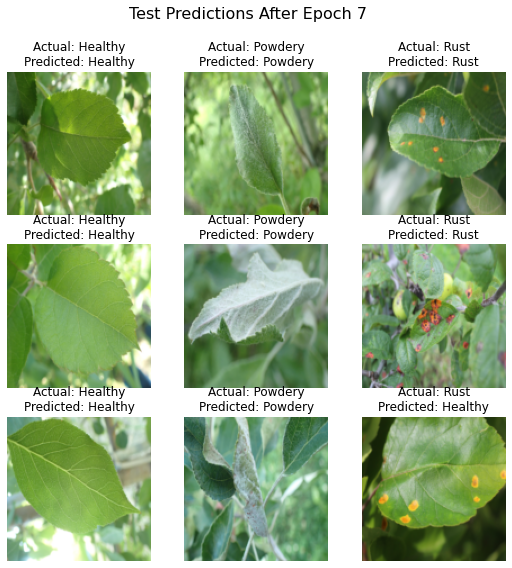

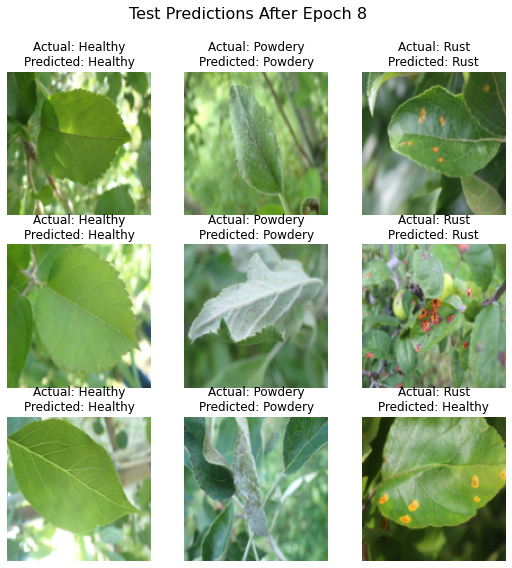

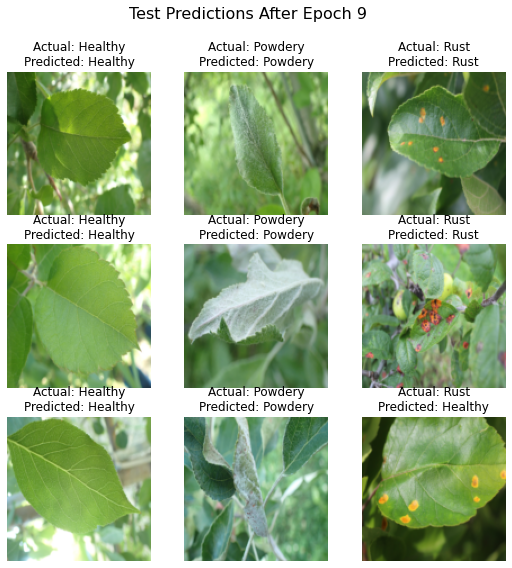

In [ ]:
# # Loading the saved model if needed
# save_path = './plant_disease_torch_cnn.pt'
# cnn_model = Net().to(device)
# cnn_model.load_state_dict(torch.load(save_path))
# cnn_model.eval()

### show some sample predictions we got earler for each epoch
# display sample images seperated for each epoch to show model progression
for i in range(epochs):
  # display some sample images to show progression for each epoch
  epoch = i + 1
  figure = plt.figure(figsize=(9, 9))
  figure.suptitle('Test Predictions After Epoch ' + str(epoch), fontsize=16)
  for j in range(cols * rows):
    img = img_list_2d[i][j]
    label = label_list_2d[i][j]
    predicted_class = predicted_class_list_2d[i][j]
    figure.add_subplot(rows, cols, j + 1)
    plt.title('Actual: '+ labels_dict[label] + '\nPredicted: '+ labels_dict[predicted_class.item()])
    plt.axis("off")
    plt.imshow(torch.moveaxis(img, 0, -1))
  plt.show()